# ましゅ(masyu)パズル

以下はましゅパズルのルールです。

1. 盤面のいくつかのマスに線を引いて全体で１つの輪っかを作りましょう。
2. 線は、マスの中央を通るようにタテヨコに引きます。線を交差させたり、枝分かれさせたりしてはいけません。
3. 線はすべての白丸と黒丸を通らなければいけません。
4. 白丸を通る線は、白丸のマスで必ず直進し、白丸の隣のマスで直角に曲がりますが、両隣で曲がる場合と片方だけで曲がる場合とがあります。
5. 黒丸を通る線は、黒丸のマスで必ず直角に曲がりますが、黒丸の隣のマスでは曲がりません。

![](https://www.nikoli.co.jp/ja/wp-content/themes/nikoli/images/puzzles/masyu03.gif)

`````{admonition}ましゅパズルのサイト
:class: tip
https://ja.puzzle-masyu.com/

`helper.puzzle.extract_masyu()` を使うと、このサイトのパズル盤面を取得できます。ブラウザの開発者ツールを開き、盤面を表す `<div>` タグのコードをコピーし、この関数を実行すると、盤面が配列として取得できます。
`````

## 盤面  

次のように二次元配列で盤面を表します。`1` は白丸マス、`2` は黒丸マスを表します。

In [12]:
from ortools.sat.python import cp_model
import numpy as np
puzzle = np.loadtxt('data/masyu01.txt', dtype=np.uint8)
print(puzzle)

[[0 1 0 0 1 0 0 2]
 [0 0 0 0 0 1 0 0]
 [0 0 2 0 0 1 0 0]
 [0 0 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 2 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 2]]


## 解き方  

ましゅパズルでは、すべての丸を通る1本のループを作成する必要があるため、CP-SATの `add_circuit()` を利用すると簡単に解くことができます。ただし、すべてのマスを通る必要はないため、白丸や黒丸がないマスについては `(i, i, bool_variable)` の制約を追加し、そのマスをループから省略できるようにします。また、白丸や黒丸のマスには特別な制約を追加する必要があります。  

`add_circuit()` で表す辺は有向辺であり、隣接する2つのマス `a` と `b` は、`a → b` と `b → a` の2つの有向辺で結びます。`add_circuit()` は、  

- どちらか一方の有向辺を `True` にする  
- 両方とも `False` にする  

という選択肢を持ちますが、両方を `True` にすることはありません。しかし、白丸や黒丸の制約条件を設定する際には、有向辺よりも無向辺で表現する方が簡単です。  

プログラムでは、有向辺 `e1` (`a → b`) と `e2` (`b → a`) を表すブール変数、および無向辺 `e` (`a -- b`) を表すブール変数を `e == e1 + e2` という制約で結びつけます。次は白丸・黒丸の制約条件を無向辺を使ってについて説明します。  

各丸があるマスに対して、上下左右に1マス移動する無向辺のブール変数を  

- $U_1$（上方向1マス）  
- $D_1$（下方向1マス）  
- $L_1$（左方向1マス）  
- $R_1$（右方向1マス）  

とし、2マス移動する無向辺のブール変数を  
- $U_2$（上方向2マス）  
- $D_2$（下方向2マス）  
- $L_2$（左方向2マス）  
- $R_2$（右方向2マス）  

とします。  

![](images/masyu.svg)

白丸のマスでは、以下の制約を追加します。  
$$
L_1 + R_1 - U_1 - D_1 \neq 0
$$ 
これは、直進または曲がることを許容しつつ、曲がる場合はその前後も曲がらなければならないことを意味します。

黒丸のマスでは、以下の制約を追加します。  
$$
L_1 + R_1 - U_1 - D_1 = 0
$$  
また、次の論理包含 (`→`) の制約も追加します。  
$$
L_1 \rightarrow L_2, \quad R_1 \rightarrow R_2, \quad U_1 \rightarrow U_2, \quad D_1 \rightarrow D_2
$$  
この制約は、黒丸で曲がった場合、その前後は必ず直進することを保証します。

## コード

次はましゅパズルを解くコードです。以下のコードのロジックです。

1. まず各マスに一意のインデックスを振るため、`nodes`に`0`から`h * w - 1`の整数の2D配列を作成します。
2. 各マス`(r, c)`に対して右`(c+1)`, 下`(r+1)`の隣接マスと接続します。有向辺`directed_edges`と無向辺`edges`をリストに追加します。
3. 次の三種類のブール変数を定義します。

    * 有向辺のブール変数`directed_edge_variables`: `a → b`の有向辺を True にすることでループを表現します。
    * 無向辺のブール変数`edge_variables`: `a -- b`をループ内に含めるかどうかを表示します。
    * ダミー変数`dummy_variables`: 白丸・黒丸がないマスをループから除外できるようにします。

4. `add_circuit()`を使用して、ループ（回路）の制約を追加します。マスをつなぐ辺をTrueにすることで、1本の閉じたループを作成できます。
5. `model.add(b == b1 + b2)`で各個無向辺`b`とそれに対応する二つの有向辺`b1`と`b2`とリンクします。
6. 最後に、前述の白丸と黒丸の制約条件を追加します。上下左右に辺が存在しない場合は `0` を使用します。黒丸の場合、範囲外の判定が必要となります。つまり、2マス先への移動が不可能な場合、その方向への1マス目の移動も必ず `False` になります。

In [27]:
def solve_masyu(puzzle):
    h, w = puzzle.shape
    nodes = np.arange(h * w).reshape(h, w)
    
    directed_edges = []
    edges = []
    for (r, c), n1 in np.ndenumerate(nodes):
        if c + 1 < w:
            n2 = nodes[r, c + 1]
            directed_edges.extend([(n1, n2), (n2, n1)])
            edges.append((n1, n2))
        if r + 1 < h:
            n2 = nodes[r + 1, c]
            directed_edges.extend([(n1, n2), (n2, n1)])
            edges.append((n1, n2))
    
    model = cp_model.CpModel()
    directed_edge_variables = {edge:model.new_bool_var(f'dedge_{edge}') for edge in directed_edges}
    edge_variables = {edge:model.new_bool_var(f'edge_{edge}') for edge in edges}
    dummy_variables = {(i, i):model.new_bool_var(f'dummy_{i}') for (r, c), i in np.ndenumerate(nodes) if puzzle[r, c] == 0}
    model.add_circuit(
        [(n1, n2, v) for (n1, n2), v in directed_edge_variables.items()] + 
        [(n1, n2, v) for (n1, n2), v in dummy_variables.items()])
    
    #edge equals the sum of two directed edge
    for (n1, n2), b in edge_variables.items():
        b1 = directed_edge_variables[n1, n2]
        b2 = directed_edge_variables[n2, n1]
        model.add(b == b1 + b2)
    
    for (r, c), num in np.ndenumerate(puzzle):
        node = nodes[r, c]
        directs = dict(u=(-1, 0), d=(1, 0), l=(0, -1), r=(0, 1))
        step1 = {}
        step2 = {}
        for name, (dr, dc) in directs.items():
            r1, c1 = r + dr, c + dc 
            r2, c2 = r + dr * 2, c + dc * 2
            if 0 <= r1 < h and 0 <= c1 < w:
                node1 = nodes[r1, c1]
                n1, n2 = sorted([node, node1])
                step1[name] = edge_variables[n1, n2]
    
                if 0 <= r2 < h and 0 <= c2 < w:
                    node2 = nodes[r2, c2]
                    n1, n2 = sorted([node1, node2])
                    step2[name] = edge_variables[n1, n2]
    
        l, r, u, d = [step1.get(direct, 0) for direct in 'lrud']
        expr = l + r - u - d
    
        if num == 1: # white node, straight line
            model.add(expr != 0)
        elif num == 2: # black node corner
            model.add(expr == 0)
            for direct in "lrud":
                if direct in step2:
                    model.add_implication(step1[direct], step2[direct])
                elif direct in step1:
                    model.add_bool_and(~step1[direct])
    
    solver = cp_model.CpSolver()
    solver.solve(model)
    route = [key for key, v in directed_edge_variables.items() if solver.value(v)]
    return route

以下は盤面と結果を描画するコードです。

In [28]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

def plot_masyu_board(puzzle, route):
    h, w = puzzle.shape
    fig, ax = plt.subplots(figsize=(w * 0.3, h * 0.3))
    segments = []
    for n1, n2 in route:
        r1, c1 = n1 // w, n1 % w
        r2, c2 = n2 // w, n2 % w
        segments.append([(c1, r1), (c2, r2)])
    
    ax.add_collection(LineCollection(segments, color='black'))
    
    r, c = np.where(puzzle == 1)
    ax.scatter(c, r, s=100, marker='o', facecolor="none", edgecolor="black")
    r, c = np.where(puzzle == 2)
    ax.scatter(c, r, s=100, marker='o', facecolor="black", edgecolor="black")
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    return fig, ax

とりあえず、簡単な盤面を解いてみます。

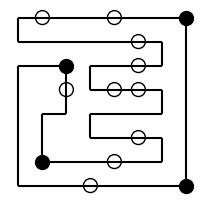

In [29]:
puzzle = np.loadtxt('data/masyu01.txt', dtype=np.uint8)
route = solve_masyu(puzzle)
plot_masyu_board(puzzle, route);

次に、最も難しい盤面を解いてみます。うまく解けます。

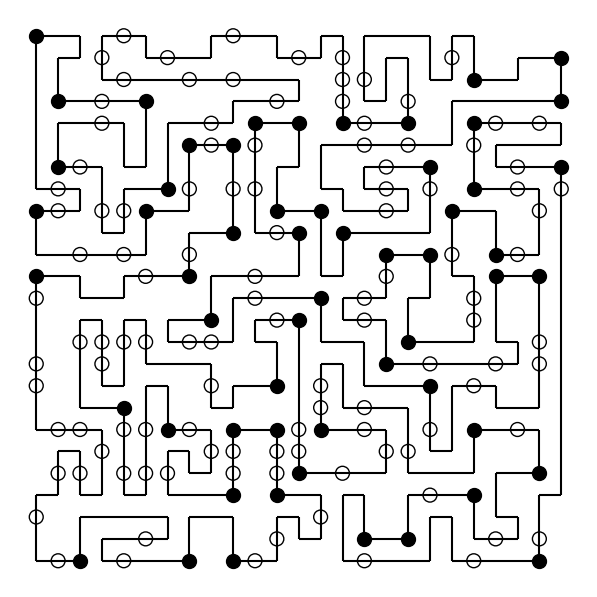

In [30]:
puzzle = np.loadtxt('data/masyu02.txt', dtype=np.uint8)
route = solve_masyu(puzzle)
plot_masyu_board(puzzle, route);